In [1]:
import os
import pickle

root_dir = "/home/kdhsimplepro/kdhsimplepro/AI/BirdDetection/"

with open(os.path.join(root_dir, "datasamples", "split_indexes.pickle"), "rb") as f:
    data_split_indexes = pickle.load(f)

print(data_split_indexes[:100])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0]


In [2]:
bird_images = []
mask_images = []
bboxes_list = []

In [3]:
from PIL import Image
from torchvision import transforms

for i in range(len(data_split_indexes)):
    if data_split_indexes[i] == 0:
        bird_path = os.path.join(root_dir, "datasamples", "images", f"{i}.jpg")
        mask_path = os.path.join(root_dir, "datasamples", "mask", f"{i}.jpg")
        bboxes_path = os.path.join(root_dir, "datasamples", "bboxes", f"{i}.txt")

        bird_image = transforms.ToTensor()(Image.open(bird_path).convert("RGB"))
        mask_image = transforms.ToTensor()(Image.open(mask_path).convert("L"))

        bboxes = []
        
        with open(bboxes_path, "r") as f:
            lines = f.readlines()

            for line in lines:
                c, x, y, w, h = map(float, line.split())
                c = int(c)

                bboxes.append([c, x, y, w, h])
        
        bird_images.append(bird_image)
        mask_images.append(mask_image)
        bboxes_list.append(bboxes)

/home/kdhsimplepro/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
len(bird_images), len(mask_images), len(bboxes_list)

(2092, 2092, 2092)

In [5]:
from PIL import ImageDraw

def draw_bbox(img, bboxes):
    image = transforms.ToPILImage()(img)
    _, H, W = img.shape

    draw = ImageDraw.Draw(image)
    
    for x, y, w, h in bboxes:
        xmin = (x - (w/2)) * W
        ymin = (y - (h/2)) * H
        xmax = (x + (w/2)) * W
        ymax = (y + (h/2)) * H

        draw.rectangle((xmin, ymin, xmax, ymax), outline=(255, 0, 0), width=3)
    
    return image

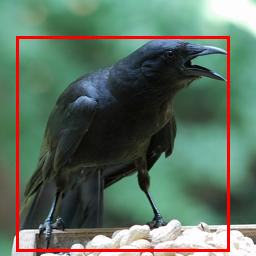

In [6]:
draw_bbox(bird_images[2], [bbox[1:] for bbox in bboxes_list[2]])

In [7]:
from glob import glob

background_images = []

for path in glob(os.path.join(root_dir, "Landscape", "*.jpg")):
    background_images.append(
        transforms.ToTensor()(Image.open(path).convert("RGB").resize((256, 256)))
    )

print(len(background_images))

4258


In [79]:
import torch
import torch.nn.functional as F

import albumentations as A
from random import uniform, randint, choices

from tqdm import tqdm
# from .autonotebook import


class BackgroundCompositor:

    def __init__(
        self,
        bird_images,
        mask_images,
        bboxes_list,
        background_images,
        iof_threshold=0.4, # intersection over front_area
        iob_threshold=0.4, # intersection over back_area
        min_size_of_bird=8,
        max_size_of_bird=256,
    ):
    
        self.img_H, self.img_W = 256, 256

        self.bird_images = bird_images
        self.mask_images = mask_images
        self.bboxes_list = bboxes_list
        self.background_images = background_images

        self.iof_threshold = iof_threshold
        self.iob_threshold = iob_threshold

        self.min_size_of_bird = min_size_of_bird
        self.max_size_of_bird = max_size_of_bird

        self.croped_bird_images = []
        self.croped_mask_images = []
        self.croped_bird_class_list = []

        self.crop_bird_and_mask_images()

        self.albumentations_dict = {
            "crop_and_pad": A.CropAndPad(percent=(-0.2,0.4), p=1),
            "rotate": A.SafeRotate(p=0.5),
            "vertical_flip": A.VerticalFlip(p=0.3),
            "horizontal_flip": A.HorizontalFlip(p=0.3),
            "random_brightness_contrast": A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
            "blur": A.AdvancedBlur(p=0.3),
            "fog": A.RandomFog(p=0.3),
        }

    
    def crop_bird_and_mask_images(
        self
    ):
        
        for bird_img, mask_img, bboxes in tqdm(zip(self.bird_images, self.mask_images, self.bboxes_list)):
            
            for c, x, y, w, h in bboxes:
                xmin, ymin, xmax, ymax = (x - w/2), (y - h/2), (x + w/2), (y + h/2)
                xmin, ymin, xmax, ymax = int(xmin * self.img_W), int(ymin * self.img_H), int(xmax * self.img_W), int(ymax * self.img_H)

                self.croped_bird_images.append(
                    bird_img[:, ymin:ymax, xmin:xmax]
                )

                self.croped_mask_images.append(
                    mask_img[:, ymin:ymax, xmin:xmax]
                )

                self.croped_bird_class_list.append(c)


    def do_transform_img(
        self,
        bird_img,
        mask_img,
        bboxes, # [[class, x, y, w, h] ... ]
        compose_list=["rotate", "vertical_flip", "horizontal_flip", "random_brightness_contrast", "blur", "fog"]
    ):

        is_bird = bird_img != None
        is_mask = mask_img != None
        is_bbox = bboxes != None

        mask_img = torch.zeros((1, bird_img.size(1), bird_img.size(2))) if not is_mask else mask_img
        bboxes = [[0, 0.5, 0.5, 0.5, 0.5]] if not is_bbox else bboxes

        transformation = A.Compose([
                self.albumentations_dict[key]
                for key in compose_list
            ], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))

        transform_result = transformation(
            image=bird_img.permute(1, 2, 0).numpy(),
            mask=mask_img.permute(1, 2, 0).numpy(),
            bboxes=[bbox[1:] for bbox in bboxes],
            class_labels=[bbox[0] for bbox in bboxes]
        )

        result = []

        if is_bird:
            result.append(torch.from_numpy(transform_result["image"]).permute(2, 0, 1))
        
        if is_mask:
            result.append(torch.from_numpy(transform_result["mask"]).permute(2, 0, 1))

        if is_bbox:
            result.append([[bboxes[i][0]] + list(bbox) for i, bbox in enumerate(transform_result["bboxes"])])

        return result
        

    def random_resize(
        self,
        bird_img,
        mask_img,
    ):
        bird_H, bird_W = bird_img.size(1), bird_img.size(2)
        
        min_scale_factor = self.min_size_of_bird / min(bird_H, bird_W)
        max_scale_factor = self.max_size_of_bird / max(bird_H, bird_W)

        random_scale_factor = uniform(min_scale_factor, max_scale_factor)
        resized_bird_img = F.interpolate(bird_img.unsqueeze(0), scale_factor=random_scale_factor).squeeze(0)
        resized_mask_img = F.interpolate(mask_img.unsqueeze(0), scale_factor=random_scale_factor).squeeze(0)

        return resized_bird_img, resized_mask_img
        # return bird_img, mask_img


    def get_random_position(
        self,
        bird_img,
        mask_img,
        background_img
    ):
        bird_H, bird_W = bird_img.size(1), bird_img.size(2)
        background_H, background_W = background_img.size(1), background_img.size(2)

        xmin = randint(0, background_W - bird_W)
        ymin = randint(0, background_H - bird_H)
        
        x = (xmin + bird_W/2) / background_W
        y = (ymin + bird_H/2) / background_H
        w = bird_W / background_W
        h = bird_H / background_H

        return (x, y, w, h)


    def do_augmentation(
        self,
        birds_n=[0, 1, 2, 3, 4, 5, 6],
        birds_n_p=[0.01, 16.5, 16.5, 16.5, 16.5, 16.5, 16.5],
        augmentation_n=50000
    ):

        augmentation_bird_images = []
        augmentation_bboxes_list = []

        for _ in range(augmentation_n):
            random_background = self.background_images[randint(0, len(self.background_images))-1]
            [number_of_birds] = choices(birds_n, weights=birds_n_p, k=1)

            bboxes = []

            pasted_img = random_background.clone()
            id_img = torch.zeros((1, pasted_img.size(1), pasted_img.size(2))).fill_(-1) # iob 를 계산하기 위한 변수.

            for new_imgid in range(number_of_birds):
                random_idx = randint(0, len(self.croped_bird_images)-1)

                bird_image = self.croped_bird_images[random_idx]
                mask_image = self.croped_mask_images[random_idx]
                class_ = self.croped_bird_class_list[random_idx]
                
                bird_image, mask_image = self.do_transform_img(
                    bird_image, mask_image, bboxes=None,
                    compose_list=["vertical_flip", "horizontal_flip", "random_brightness_contrast"])

                bird_image, mask_image = self.random_resize(bird_image, mask_image)

                random_position = self.get_random_position(bird_image, mask_image, pasted_img)

                its_ok = True


                # -------------------------- 이 부분도 더 확인하여 수정해야 함 -------------------------------
                # ------------------- 알고리즘이 의도한대로 작동하는지 아직 확인되지 않음 -----------------------
                # --------------------- intersection_area가 음수가 나올때가 있음 ---------------------------
                for imgid, (_, x, y, w, h) in enumerate(bboxes):
                    new_x, new_y, new_w, new_h = random_position
                    new_x, new_y, new_w, new_h = int(new_x * 256), int(new_y * 256), int(new_w * 256), int(new_h * 256)
                    new_xmin, new_ymin = int(new_x - new_w/2), int(new_y - new_h/2)
                    new_xmax, new_ymax = new_xmin + new_w, new_ymin + new_h
                    # print(f"new_xmin: {new_xmin}, new_ymin: {new_ymin}, new_xmax: {new_xmax}, new_ymax: {new_ymax}")
                    
                    x, y, w, h = int(x * 256), int(y * 256), int(w * 256), int(h * 256)
                    xmin, ymin, xmax, ymax = int(x - w/2), int(y - h/2), int(x + w/2), int(y + h/2)
                    # print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

                    front_area = new_w * new_h # 새로 붙일 이미지의 넓이

                    i_xmin, i_ymin = max(xmin, new_xmin), max(ymin, new_ymin)
                    i_xmax, i_ymax = min(xmax, new_xmax), min(ymax, new_ymax)
                    # print(f"i_xmin: {i_xmin}, i_ymin: {i_ymin}, i_xmax: {i_xmax}, i_ymax: {i_ymax}")
                    intersection_area = (i_xmax - i_xmin) * (i_ymax - i_ymin)
                    if intersection_area < 0:
                        intersection_area = 0
                    # print(f"intersection_area: {intersection_area}, front_area: {front_area}")

                    iof = intersection_area / front_area
                    print("iof", iof)

                    if iof > self.iof_threshold:
                        its_ok = False
                        break
                    
                    back_area = w * h
                    intersection_area = torch.sum(id_img[:, ymin:ymax, xmin:xmax] != imgid) + intersection_area
                    # print(f"intersection_area: {intersection_area}, back_area: {back_area}")
                    iob = (intersection_area / back_area).item()
                    print("iob", iob)

                    if iob > self.iob_threshold:
                        its_ok = False
                        break

                if its_ok:
                    x, y, w, h = random_position
                    x, y, w, h = int(x * 256), int(y * 256), int(w * 256), int(h * 256)
                    xmin, ymin = int(x - w/2), int(y - h/2)
                    xmax, ymax = xmin + w, ymin + h

                    id_img[:, ymin:ymax, xmin:xmax] = new_imgid

                    pasted_img[:, ymin:ymax, xmin:xmax] = (bird_image * torch.sqrt(mask_image)) + (pasted_img[:, ymin:ymax, xmin:xmax] * (1 - torch.sqrt(mask_image)))

                    bboxes.append([class_, *random_position])
                            
                            
            pasted_img, bboxes = self.do_transform_img(
                bird_img=pasted_img,
                mask_img=None,
                bboxes=bboxes,
                compose_list=["horizontal_flip", "random_brightness_contrast", "blur"])

            augmentation_bird_images.append(pasted_img)
            augmentation_bboxes_list.append(bboxes)
                


        return augmentation_bird_images, augmentation_bboxes_list

In [80]:
background_compositor = BackgroundCompositor(bird_images, mask_images, bboxes_list, background_images)

2092it [00:00, 212056.74it/s]


In [81]:
augmentation_bird_images, augmentation_bboxes_list = background_compositor.do_augmentation(augmentation_n=1)

iof 0.7383177570093458
iof 0.7666666666666667
iof 0.18511018463371054
iob 0.1377171277999878
iof 0.6706885791553984


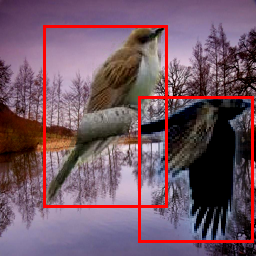

In [82]:
draw_bbox(augmentation_bird_images[0], [bbox[1:] for bbox in augmentation_bboxes_list[0]])